In [3]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()  # for plot styling
import matplotlib.pyplot as plt
pd.options.mode.copy_on_write = True 
import datetime 

# Analisis Exploratorio de datos de Turismo en Argentina

##  Datos

### Fuente Datos Argentina datos.gob.ar

1) **pernoctes_por_localidad_segun_residencia.csv**: Pernoctaciones en hoteles y parahoteles por localidad de destino según tipo de residencia Cantidad de noches en hoteles y parahoteles por localidad de destino según tipo de residencia en formato de series de tiempo
https://datos.gob.ar/dataset/turismo_93db331e-6970-4d74-8589-c1223ac9c282/archivo/turismo_7b6ba47f-4aa9-4743-96be-d0e6157cfc5e


2) **coordenadas.csv**: valores de latitud y longitud de localidades Argentinas

3) **puna_base_agregada.csv**: Base agrupada del Padrón Único Nacional de Alojamiento (PUNA):
Base agrupada del Padrón Único Nacional de Alojamiento con datos de establecimientos, unidades, habitaciones y plazas de alojamientos turísticos.https://datos.gob.ar/dataset/turismo-padron-unico-nacional-alojamiento/archivo/turismo_01d23e57-ba58-48ed-a1c9-e1604ae78a1d


### 1. pernoctes_por_localidad_segun_residencia.csv
***

In [4]:
pernoctes=pd.read_csv('../Datos/pernoctes_por_localidad_segun_residencia.csv')

In [5]:
pernoctes.head(3)

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones
0,2018-01-01,Bahía Blanca,Total,16619.0,NaN
1,2018-01-01,Bahía Blanca,Residentes,15784.0,NaN
2,2018-01-01,Bahía Blanca,No residentes,835.0,NaN


### 2. coordenadas.csv
***

In [6]:
coord_loc=pd.read_csv('../Datos/coordenadas.csv', encoding='latin')

In [7]:
coord_loc.head(3)

,Localidad,Latitud,Longitud
0,Bahía Blanca,-38.7196,-62.2724
1,Bariloche,-41.1335,-71.3100
2,CABA,-34.6118,-58.4173


In [8]:
coord_loc.rename(columns={'Localidad':'localidad'}, inplace=True)

### 3. puna_base_agregada.csv
***

In [9]:
base_alojamientos=pd.read_csv('../Datos/puna_base_agregada.csv', encoding='latin')

In [10]:
base_alojamientos.head(1)

,indice_tiempo,region,ruta_natural,provincia_codigo,provincia_nombre,departamento_partido,localidad,clasificacion_minturdep,tipo,establecimientos,unidades,habitaciones,plazas
0,2020,Buenos Aires,Delta,6,Buenos Aires,Baradero,Baradero,Albergue municipal / complejo deportivo,Otros colectivos,1,0,6,30


In [11]:
base_alojamientos['tipo'].unique()

array(['Otros colectivos', 'Parahoteleros', 'Hoteleros'], dtype=object)

Creo una mascara para quedarme solo con los datos de tipo Parahoteleros y Hoteleros ya que el dataset de pernoctes_por_localidad_de_Residencia  solo cuenta con estas dos categorias. 

In [12]:
mascara_tipo=base_alojamientos['tipo'].isin(['Parahoteleros', 'Hoteleros'])

In [13]:
base_alojamientos=base_alojamientos[mascara_tipo]

Agrupo los plazas por localidad

In [14]:
base_alojamientos_agrupado=base_alojamientos.groupby(['indice_tiempo','localidad'])['plazas'].sum().reset_index()

Verifico los datos de palzas para la ciudad de Bariloche

In [15]:
base_alojamientos_agrupado[base_alojamientos_agrupado['localidad']=='San Carlos de Bariloche']

,indice_tiempo,localidad,plazas
878,2020,San Carlos de Bariloche,24207
2030,2021,San Carlos de Bariloche,24039
3181,2022,San Carlos de Bariloche,24653


Genero Diccionario de reemplazo de localidades para normalizarlas con el  dataset de pernoctes_por_localidad_de_Residencia. Comparé como estaban escritas las localidades en los dos datasets y cree este diccionario de sustiuciones para despues poder unirlos por localidad. 

In [16]:
reemplazo={'Bahía Blanca':'Bahia Blanca', 'Bariloche':'San Carlos de Bariloche', 'CABA':'Ciudad Autonoma de Buenos Aires', 'Calafate':'El Calafate', 'Carlos Paz':'Villa Carlos Paz',
       'Catamarca':'San Fernando del Valle de Catamarca', 'Córdoba':'Cordoba', 'Gualeguaychú':'Gualeguaychu', 'Jujuy':'San Salvador de Jujuy', 'La Angostura':'Villa La Angostura',
       'Malargue-Las Leñas':'Las Leñas', 'Neuquén':'Neuquen', 'Paraná':'Parana', 'Puerto Iguazú':'Puerto Iguazu',
       'Río Cuarto':'Rio Cuarto', 'San Martín de los Andes':'San Martin', 'Termas':'Termas de Rio Hondo', 'Tucumán':'San Miguel de Tucuman',
       'Valle de Uco':'Tunuyan'}

# Uniones de dataset

### Agregar coordenadas de localidad al dataset pernoctes

In [17]:
union_pernoctes=pd.merge(pernoctes, coord_loc, on='localidad')

Convierto columna indice_tiempo a datetime y agrego una columna que sea año

In [18]:
union_pernoctes['indice_tiempo']=pd.to_datetime(union_pernoctes['indice_tiempo'])
union_pernoctes['Año']=union_pernoctes['indice_tiempo'].dt.year

### Union con dataset de plazas

Utilizo el diccionario reemplazo para Normalizar las locaclidades entre los datasets de pernoctes y base_alojamiento.

In [19]:
union_pernoctes.localidad=union_pernoctes.localidad.replace(reemplazo)

In [20]:
base_alojamientos_agrupado.head(2)

,indice_tiempo,localidad,plazas
0,2020,25 de Mayo,419
1,2020,28 de Noviembre,81


In [21]:
base_alojamientos_agrupado.columns

Index(['indice_tiempo', 'localidad', 'plazas'], dtype='object')

In [22]:
base_alojamientos_agrupado.rename(columns={'indice_tiempo':'Año'}, inplace=True)

In [23]:
union_pernoctes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10584 entries, 0 to 10583
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   indice_tiempo     10584 non-null  datetime64[ns]
 1   localidad         10584 non-null  object        
 2   origen_pernoctes  10584 non-null  object        
 3   pernoctes         8825 non-null   float64       
 4   observaciones     3366 non-null   object        
 5   Latitud           10584 non-null  float64       
 6   Longitud          10584 non-null  float64       
 7   Año               10584 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), object(3)
memory usage: 620.3+ KB


Union del dataset con pernoctes y cantidad de plazas por localidad

In [24]:
pernoctes_con_plazas=pd.merge(union_pernoctes,base_alojamientos_agrupado, on=['localidad','Año'], how='left')

In [25]:
pernoctes_con_plazas[pernoctes_con_plazas['localidad']=='San Carlos de Bariloche']

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas
3,2018-01-01,San Carlos de Bariloche,Total,324603.0,NaN,-41.1335,-71.31,2018,NaN
4,2018-01-01,San Carlos de Bariloche,Residentes,254665.0,NaN,-41.1335,-71.31,2018,NaN
5,2018-01-01,San Carlos de Bariloche,No residentes,69938.0,NaN,-41.1335,-71.31,2018,NaN
150,2018-02-01,San Carlos de Bariloche,Total,271748.0,NaN,-41.1335,-71.31,2018,NaN
151,2018-02-01,San Carlos de Bariloche,Residentes,209620.0,NaN,-41.1335,-71.31,2018,NaN
...,...,...,...,...,...,...,...,...,...
10294,2023-11-01,San Carlos de Bariloche,Residentes,178831.0,Dato provisorio,-41.1335,-71.31,2023,NaN
10295,2023-11-01,San Carlos de Bariloche,No residentes,62489.0,Dato provisorio,-41.1335,-71.31,2023,NaN
10440,2023-12-01,San Carlos de Bariloche,Total,310615.0,Dato provisorio,-41.1335,-71.31,2023,NaN
10441,2023-12-01,San Carlos de Bariloche,Residentes,197496.0,Dato provisorio,-41.1335,-71.31,2023,NaN


In [26]:
nulos =pernoctes_con_plazas[pernoctes_con_plazas['plazas'].isna()]

In [27]:
nulos['localidad'].unique()

array(['Bahia Blanca', 'San Carlos de Bariloche',
       'Ciudad Autonoma de Buenos Aires', 'Cafayate', 'El Calafate',
       'Villa Carlos Paz', 'San Fernando del Valle de Catamarca',
       'Cordoba', 'Corrientes', 'Formosa', 'Gualeguaychu',
       'San Salvador de Jujuy', 'Villa La Angostura', 'La Falda',
       'La Rioja', 'Las Grutas', 'Las Leñas', 'Mar Chiquita',
       'Mar del Plata', 'Mendoza', 'Merlo', 'Mina Clavero', 'Neuquen',
       'Parana', 'Pinamar', 'Posadas', 'Puerto Iguazu', 'Puerto Madryn',
       'Rafaela', 'Resistencia', 'Rio Cuarto', 'Rio Gallegos', 'Rosario',
       'Salta', 'San Juan', 'San Luis', 'San Martin', 'San Rafael',
       'Santa Fe', 'Santa Rosa', 'Santiago del Estero', 'Tandil',
       'Termas de Rio Hondo', 'San Miguel de Tucuman', 'Ushuaia',
       'Tunuyan', 'Viedma', 'Villa General Belgrano', 'Villa Gesell'],
      dtype=object)

In [28]:
pernoctes_con_plazas[pernoctes_con_plazas['Año']==2022]

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas
7056,2022-01-01,Bahia Blanca,Total,15079.0,NaN,-38.7196,-62.2724,2022,1823.0
7057,2022-01-01,Bahia Blanca,Residentes,14690.0,NaN,-38.7196,-62.2724,2022,1823.0
7058,2022-01-01,Bahia Blanca,No residentes,389.0,NaN,-38.7196,-62.2724,2022,1823.0
7059,2022-01-01,San Carlos de Bariloche,Total,388088.0,NaN,-41.1335,-71.3100,2022,24653.0
7060,2022-01-01,San Carlos de Bariloche,Residentes,380605.0,NaN,-41.1335,-71.3100,2022,24653.0
...,...,...,...,...,...,...,...,...,...
8815,2022-12-01,Villa General Belgrano,Residentes,36984.0,NaN,-31.9795,-64.5293,2022,3204.0
8816,2022-12-01,Villa General Belgrano,No residentes,560.0,NaN,-31.9795,-64.5293,2022,3204.0
8817,2022-12-01,Villa Gesell,Total,140390.0,NaN,-37.2634,-56.9730,2022,17704.0
8818,2022-12-01,Villa Gesell,Residentes,140390.0,NaN,-37.2634,-56.9730,2022,17704.0


In [29]:
pernoctes_con_plazas.localidad.unique()

array(['Bahia Blanca', 'San Carlos de Bariloche',
       'Ciudad Autonoma de Buenos Aires', 'Cafayate', 'El Calafate',
       'Villa Carlos Paz', 'San Fernando del Valle de Catamarca',
       'Cordoba', 'Corrientes', 'Formosa', 'Gualeguaychu',
       'San Salvador de Jujuy', 'Villa La Angostura', 'La Falda',
       'La Rioja', 'Las Grutas', 'Las Leñas', 'Mar Chiquita',
       'Mar del Plata', 'Mendoza', 'Merlo', 'Mina Clavero', 'Neuquen',
       'Parana', 'Pinamar', 'Posadas', 'Puerto Iguazu', 'Puerto Madryn',
       'Rafaela', 'Resistencia', 'Rio Cuarto', 'Rio Gallegos', 'Rosario',
       'Salta', 'San Juan', 'San Luis', 'San Martin', 'San Rafael',
       'Santa Fe', 'Santa Rosa', 'Santiago del Estero', 'Tandil',
       'Termas de Rio Hondo', 'San Miguel de Tucuman', 'Ushuaia',
       'Tunuyan', 'Viedma', 'Villa General Belgrano', 'Villa Gesell'],
      dtype=object)

Guardo del dataset obtenido en un archivos CSV

In [30]:
union_pernoctes.to_csv('turismo_con_plazas')

### Datos de Google trends interest over time "Alojamiento Bariloche" en mundo
***

En esta seccion voy a agregar los datos de google trens al realizar la busqueda de las palabras alojamiento Bariloche en los ultimos 5 años.  El resultado es a nivel mundial. La bajada de datos la realice directamente desde la paginad e google trends aunque luego utilizare la API pytrends.

In [41]:
data=pd.read_csv('../Datos/datos_entrenamiento.csv').drop(columns='Unnamed: 0')


In [42]:
data

,date,Bariloche,isPartial,Mes,Año
0,2019-03-17,55,False,3,2019
1,2019-03-24,52,False,3,2019
2,2019-03-31,47,False,3,2019
3,2019-04-07,51,False,4,2019
4,2019-04-14,54,False,4,2019
...,...,...,...,...,...
255,2024-02-04,71,False,2,2024
256,2024-02-11,65,False,2,2024
257,2024-02-18,65,False,2,2024
258,2024-02-25,59,False,2,2024


In [43]:
bariloche_agrupado=data.groupby(['Año','Mes'])['Bariloche'].mean().reset_index()

In [44]:
bariloche_agrupado

,Año,Mes,Bariloche
0,2019,3,51.333333
1,2019,4,51.500000
2,2019,5,54.750000
3,2019,6,65.800000
4,2019,7,81.750000
...,...,...,...
56,2023,11,59.250000
57,2023,12,63.200000
58,2024,1,79.500000
59,2024,2,65.000000


### Union de trends con dataset de pernoctes y plazas

In [52]:
pernoctes_con_plazas['Mes']=pernoctes_con_plazas['indice_tiempo'].dt.month

In [53]:
pernoctes_con_plazas

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes
0,2018-01-01,Bahia Blanca,Total,16619.0,NaN,-38.7196,-62.2724,2018,NaN,1
1,2018-01-01,Bahia Blanca,Residentes,15784.0,NaN,-38.7196,-62.2724,2018,NaN,1
2,2018-01-01,Bahia Blanca,No residentes,835.0,NaN,-38.7196,-62.2724,2018,NaN,1
3,2018-01-01,San Carlos de Bariloche,Total,324603.0,NaN,-41.1335,-71.3100,2018,NaN,1
4,2018-01-01,San Carlos de Bariloche,Residentes,254665.0,NaN,-41.1335,-71.3100,2018,NaN,1
...,...,...,...,...,...,...,...,...,...,...
10579,2023-12-01,Villa General Belgrano,Residentes,37698.0,Dato provisorio,-31.9795,-64.5293,2023,NaN,12
10580,2023-12-01,Villa General Belgrano,No residentes,495.0,Dato provisorio,-31.9795,-64.5293,2023,NaN,12
10581,2023-12-01,Villa Gesell,Total,108886.0,Dato provisorio,-37.2634,-56.9730,2023,NaN,12
10582,2023-12-01,Villa Gesell,Residentes,108860.0,Dato provisorio,-37.2634,-56.9730,2023,NaN,12


Me quedo solo con los datos de pernoctes y plazas de Bariloche para unirlo con los trends de google, ademas me quedo solo con la categoria Todos de tipo de residente (que es la suma de los residentes mas los no residentes)

In [54]:
pernoctes_con_plazas_bari=pernoctes_con_plazas[(pernoctes_con_plazas['localidad']=='San Carlos de Bariloche')  & (pernoctes_con_plazas['origen_pernoctes']=='Total')]

In [55]:
pernoctes_con_plazas_bari

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes
3,2018-01-01,San Carlos de Bariloche,Total,324603.0,NaN,-41.1335,-71.31,2018,NaN,1
150,2018-02-01,San Carlos de Bariloche,Total,271748.0,NaN,-41.1335,-71.31,2018,NaN,2
297,2018-03-01,San Carlos de Bariloche,Total,168184.0,NaN,-41.1335,-71.31,2018,NaN,3
444,2018-04-01,San Carlos de Bariloche,Total,122681.0,NaN,-41.1335,-71.31,2018,NaN,4
591,2018-05-01,San Carlos de Bariloche,Total,84772.0,NaN,-41.1335,-71.31,2018,NaN,5
...,...,...,...,...,...,...,...,...,...,...
9852,2023-08-01,San Carlos de Bariloche,Total,388352.0,Dato provisorio,-41.1335,-71.31,2023,NaN,8
9999,2023-09-01,San Carlos de Bariloche,Total,371970.0,Dato provisorio,-41.1335,-71.31,2023,NaN,9
10146,2023-10-01,San Carlos de Bariloche,Total,314773.0,Dato provisorio,-41.1335,-71.31,2023,NaN,10
10293,2023-11-01,San Carlos de Bariloche,Total,241320.0,Dato provisorio,-41.1335,-71.31,2023,NaN,11


Unir datos de pernoctes con trends de google

In [56]:
union_con_trens=pd.merge(pernoctes_con_plazas_bari,bariloche_agrupado, on=['Mes','Año'])

In [57]:
union_con_trens.rename(columns={'Bariloche':'valor'}, inplace=True)

## Agrego una columna que tenga el valor de busquedas del mes anterior y otro que sea el promedio de los ultimos 4 valores

In [58]:
union_con_trens['valor_mes_anterior'] = union_con_trens['valor'].shift(1)

In [59]:
ultimo_indice = union_con_trens.index[-1]

# Elimina el último registro usando el método drop
union_con_trens = union_con_trens.drop(ultimo_indice)

In [60]:
# Agregar la columna 'promedio_ultimos_4_valores'
union_con_trens['promedio_ultimos_4_valores'] = union_con_trens['valor'].rolling(window=3).mean()

In [61]:
union_con_trens['valor_mes_año_anterior'] = union_con_trens['valor'].shift(12)  # 12 meses en un año

In [62]:
union_con_trens.head(5)

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes,valor,valor_mes_anterior,promedio_ultimos_4_valores,valor_mes_año_anterior
0,2019-03-01,San Carlos de Bariloche,Total,166884.0,NaN,-41.1335,-71.31,2019,NaN,3,51.333333,NaN,NaN,NaN
1,2019-04-01,San Carlos de Bariloche,Total,127177.0,NaN,-41.1335,-71.31,2019,NaN,4,51.500000,51.333333,NaN,NaN
2,2019-05-01,San Carlos de Bariloche,Total,92354.0,NaN,-41.1335,-71.31,2019,NaN,5,54.750000,51.500000,52.527778,NaN
3,2019-06-01,San Carlos de Bariloche,Total,143065.0,NaN,-41.1335,-71.31,2019,NaN,6,65.800000,54.750000,57.350000,NaN
4,2019-07-01,San Carlos de Bariloche,Total,372696.0,NaN,-41.1335,-71.31,2019,NaN,7,81.750000,65.800000,67.433333,NaN


In [63]:
# dicionarios para hacer ajustes de mes y fechas
dic_mes ={
    1: 31,
    2: 28,
    3: 31,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31
}

In [64]:
union_con_trens['total_plazas_mes']=(union_con_trens['Mes'].replace(dic_mes))*24653

In [73]:
union_con_trens['ocupacion']=(union_con_trens['pernoctes'] /union_con_trens['total_plazas_mes'])*100

In [76]:
union_con_trens['ocupacion']

0     21.836510
1     17.195608
2     12.084376
3     19.343826
4     48.766688
5     48.117418
6     39.671304
7     27.113758
8     19.412648
9     30.591971
10    38.416446
11    36.255367
12    12.576890
13     0.000000
14     0.000000
15     0.026772
16     0.017926
17     0.054040
18     0.027583
19     0.027740
20     0.140754
21     4.458791
22    23.990144
23    25.100393
24    16.506923
25    10.523128
26     2.362861
27     4.278587
28    19.606329
29    20.341828
30    22.183642
31    25.811293
32    33.241931
33    34.661619
34    50.780707
35    47.540433
36    32.151423
37    21.399154
38    15.172923
39    22.608607
40    48.528282
41    44.313523
42    46.058897
43    34.662797
44    22.943523
45    36.142300
46    45.821421
47    41.418749
48    26.390297
49    22.580889
50    18.610311
51    30.145080
52    51.082967
53    50.815251
54    50.294082
55    41.187554
56    32.628889
Name: ocupacion, dtype: float64

## Analisis de Datos
### Grafico los valores de pernoctes en Bariloche y intereset over time de Alojamientos Bariloche

Valores de cantidad de pernoctes y valor de interes en google en el tiempo.

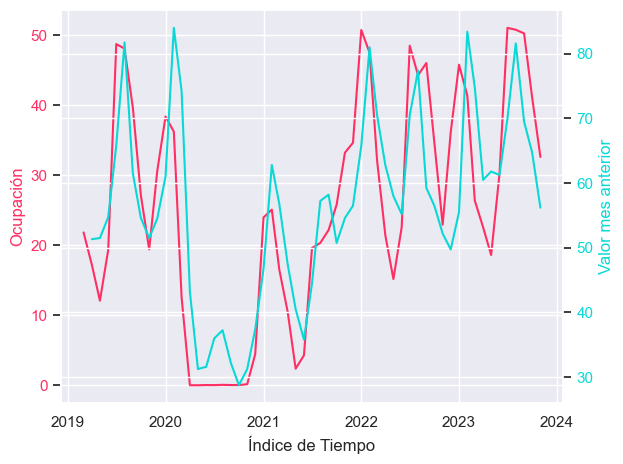

In [77]:

# Filtrar el DataFrame para obtener solo las columnas relevantes
df_filtrado = union_con_trens[['indice_tiempo', 'pernoctes','ocupacion', 'valor','valor_mes_anterior','promedio_ultimos_4_valores','Mes','Año','valor_mes_año_anterior']]

# Configurar el gráfico
fig, ax1 = plt.subplots()

# Graficar la primera variable en el eje y izquierdo
ax1.set_xlabel('Índice de Tiempo')
ax1.set_ylabel('Ocupación', color='#FF2E63')
ax1.plot(df_filtrado['indice_tiempo'], df_filtrado['ocupacion'], color='#FF2E63')
ax1.tick_params(axis='y', labelcolor='#FF2E63')

# Crear un segundo eje y para la segunda variable
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Valor mes anterior', color='#08D9D6')
ax2.plot(df_filtrado['indice_tiempo'], df_filtrado['valor_mes_anterior'], color='#08D9D6')
ax2.tick_params(axis='y', labelcolor='#08D9D6')

# Ajustar el diseño para evitar solapamiento
fig.tight_layout()

# Mostrar el gráfico
plt.show()


In [79]:
df_filtrado['indice_tiempo']=pd.to_datetime(df_filtrado['indice_tiempo'])

In [80]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   indice_tiempo               57 non-null     datetime64[ns]
 1   pernoctes                   57 non-null     float64       
 2   ocupacion                   57 non-null     float64       
 3   valor                       57 non-null     float64       
 4   valor_mes_anterior          56 non-null     float64       
 5   promedio_ultimos_4_valores  55 non-null     float64       
 6   Mes                         57 non-null     int32         
 7   Año                         57 non-null     int32         
 8   valor_mes_año_anterior      45 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int32(2)
memory usage: 3.7 KB


In [81]:
#df_filtrado.index = pd.PeriodIndex(df_filtrado.indice_tiempo, freq='M')
#df_filtrado["timeIndex"] = pd.Series(np.arange(len(df_filtrado['ocupacion'])), index=df_filtrado.index)

In [82]:
df_filtrado.head(2)

,indice_tiempo,pernoctes,ocupacion,valor,valor_mes_anterior,promedio_ultimos_4_valores,Mes,Año,valor_mes_año_anterior
0,2019-03-01,166884.0,21.836510,51.333333,NaN,NaN,3,2019,NaN
1,2019-04-01,127177.0,17.195608,51.500000,51.333333,NaN,4,2019,NaN


In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts=df_filtrado[['ocupacion']]
seasonality = 12 
result = seasonal_decompose(ts, model='additive', period=seasonality)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

In [84]:

#df_filtrado = df_filtrado.set_index('indice_tiempo')
#y = df_filtrado['ocupacion'].resample('MS').mean()

#import statsmodels.api as sm
#plt.figure(figsize=(16,10))
#decomposition = sm.tsa.seasonal_decompose(y, model='additive')
#decomposition.plot()
#plt.show()

Pernoctes vs promedio de valores de trens de ultimos 4 meses.

<Axes: xlabel='promedio_ultimos_4_valores', ylabel='pernoctes'>

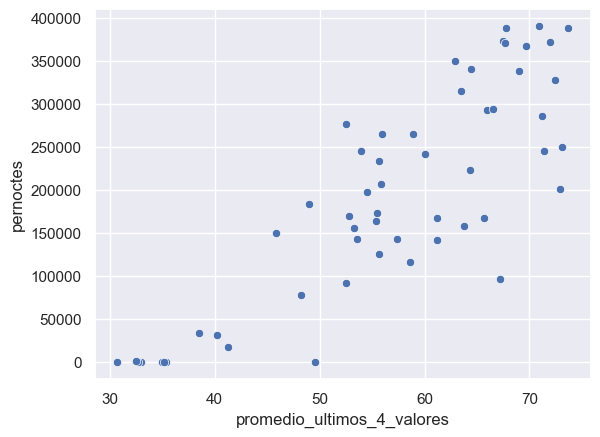

In [87]:
sns.scatterplot(data=union_con_trens, y='pernoctes', x='promedio_ultimos_4_valores')

Pernoctes vs valor interes

<Axes: xlabel='valor', ylabel='pernoctes'>

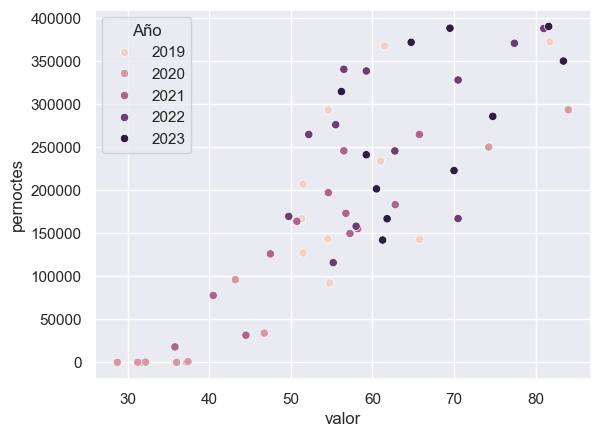

In [88]:
sns.scatterplot(data=union_con_trens, y='pernoctes', x='valor',hue='Año')

Pernoctes vs valor interes mes anterior

<Axes: xlabel='valor_mes_anterior', ylabel='pernoctes'>

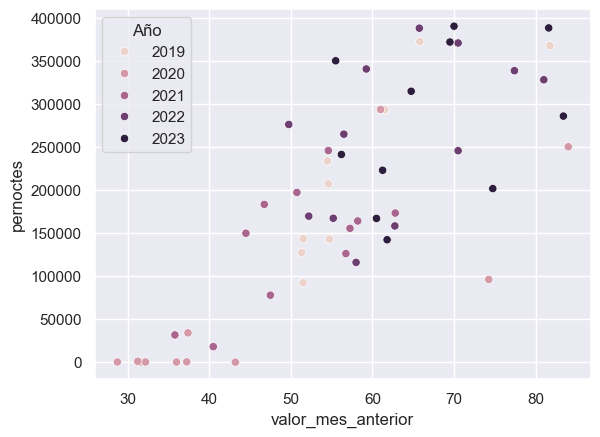

In [89]:
sns.scatterplot(data=union_con_trens, y='pernoctes', x='valor_mes_anterior',hue='Año')

### MODELO DE PREDICCION DE PERNOCTES MENSUAL EN BARILOCHE

Hago dos copias del dataframe creado para poder ver la performance del modelo convirtiendo mes y año a dummies y sin convertir. 

In [90]:
df=df_filtrado.copy()

In [91]:
df.head(3)

,indice_tiempo,pernoctes,ocupacion,valor,valor_mes_anterior,promedio_ultimos_4_valores,Mes,Año,valor_mes_año_anterior
0,2019-03-01,166884.0,21.836510,51.333333,NaN,NaN,3,2019,NaN
1,2019-04-01,127177.0,17.195608,51.500000,51.333333,NaN,4,2019,NaN
2,2019-05-01,92354.0,12.084376,54.750000,51.500000,52.527778,5,2019,NaN


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   indice_tiempo               57 non-null     datetime64[ns]
 1   pernoctes                   57 non-null     float64       
 2   ocupacion                   57 non-null     float64       
 3   valor                       57 non-null     float64       
 4   valor_mes_anterior          56 non-null     float64       
 5   promedio_ultimos_4_valores  55 non-null     float64       
 6   Mes                         57 non-null     int32         
 7   Año                         57 non-null     int32         
 8   valor_mes_año_anterior      45 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int32(2)
memory usage: 3.7 KB


In [93]:
df['Mes'] = df['Mes'].astype(str)
df['Año'] = df['Año'].astype(str)

In [94]:
df = pd.get_dummies(df, columns=['Mes', 'Año'], prefix=['Mes', 'Año'], drop_first=True, dtype=int )

In [95]:
df.head()

,indice_tiempo,pernoctes,ocupacion,valor,valor_mes_anterior,promedio_ultimos_4_valores,valor_mes_año_anterior,Mes_10,Mes_11,Mes_12,...,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Año_2020,Año_2021,Año_2022,Año_2023
0,2019-03-01,166884.0,21.836510,51.333333,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-04-01,127177.0,17.195608,51.500000,51.333333,NaN,NaN,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2019-05-01,92354.0,12.084376,54.750000,51.500000,52.527778,NaN,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2019-06-01,143065.0,19.343826,65.800000,54.750000,57.350000,NaN,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2019-07-01,372696.0,48.766688,81.750000,65.800000,67.433333,NaN,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [96]:
df.columns

Index(['indice_tiempo', 'pernoctes', 'ocupacion', 'valor',
       'valor_mes_anterior', 'promedio_ultimos_4_valores',
       'valor_mes_año_anterior', 'Mes_10', 'Mes_11', 'Mes_12', 'Mes_2',
       'Mes_3', 'Mes_4', 'Mes_5', 'Mes_6', 'Mes_7', 'Mes_8', 'Mes_9',
       'Año_2020', 'Año_2021', 'Año_2022', 'Año_2023'],
      dtype='object')

In [97]:
df = pd.concat([df, df_filtrado[['Año', 'Mes']]], axis=1)

In [98]:
df.head(3)

,indice_tiempo,pernoctes,ocupacion,valor,valor_mes_anterior,promedio_ultimos_4_valores,valor_mes_año_anterior,Mes_10,Mes_11,Mes_12,...,Mes_6,Mes_7,Mes_8,Mes_9,Año_2020,Año_2021,Año_2022,Año_2023,Año,Mes
0,2019-03-01,166884.0,21.836510,51.333333,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,2019,3
1,2019-04-01,127177.0,17.195608,51.500000,51.333333,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,2019,4
2,2019-05-01,92354.0,12.084376,54.750000,51.500000,52.527778,NaN,0,0,0,...,0,0,0,0,0,0,0,0,2019,5


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import optuna

### 1. Regresion Lineal

In [100]:

# Ordenar por 'indice_tiempo'
df = df.sort_values(by='indice_tiempo')

# Imputar valores nulos
# df = df.fillna(0)  # Puedes usar diferentes estrategias para imputar valores nulos según tus necesidades

# Definir las features (X) y la target (y)
features = ['valor']
target = ['pernoctes']

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Inicializar el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')
# Imprimir los coeficientes del modelo
print('Coeficientes del modelo:')
for feature, coef in zip(features, model.coef_):
    print(f'{feature}: {coef}')

# Imprimir el intercepto del modelo
print(f'Intercepto del modelo: {model.intercept_}')


Mean Squared Error: 5971391831.735444
r2: 0.11752344736854314
Coeficientes del modelo:
valor: [7211.47463051]
Intercepto del modelo: [-222124.96466329]


### 2. Arbol de Decisión 

        Real  Predicción
45  276215.0    169688.0
46  350187.0    126153.0
47  285907.0    328164.0
48  201686.0    245715.0
49  167006.0    158266.0
50  142228.0    158266.0
51  222950.0    293405.0
52  390398.0    370874.0
53  388352.0    338663.0
54  371970.0    370874.0
55  314773.0    372696.0
56  241320.0    264908.0


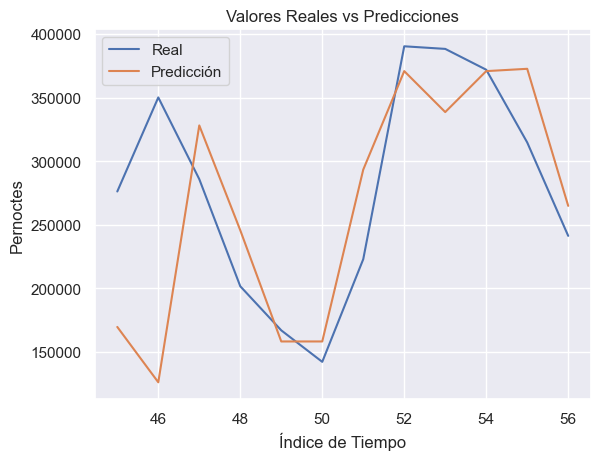

Mean Squared Error: 6443650502.5
r2: 0.04773114174362503


In [101]:


# Ordenar por 'indice_tiempo'
df = df.sort_values(by='indice_tiempo')

# Imputar valores nulos
df = df.fillna(0)  # Puedes usar diferentes estrategias para imputar valores nulos según tus necesidades

# Definir las features (X) y la target (y)
features = ['valor_mes_anterior','Mes','Año']
target = 'pernoctes'

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Inicializar el modelo de árbol de decisión
model = DecisionTreeRegressor()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Mostrar los valores reales y las predicciones
results_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(results_df)

# Graficar los resultados
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Pernoctes')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')



### 3. Arbol de Decisión con Dummies

In [103]:
df = df.fillna(0)
features = ['valor_mes_anterior',
        'Mes_10', 'Mes_11', 'Mes_12', 'Mes_2', 'Mes_3', 'Mes_4',
       'Mes_5', 'Mes_6', 'Mes_7', 'Mes_8', 'Mes_9', 'Año_2020',
       'Año_2021', 'Año_2022', 'Año_2023']
target = 'pernoctes'

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Inicializar el modelo de árbol de decisión
model = DecisionTreeRegressor()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')

Mean Squared Error: 8691400918.416666
r2: -0.28445054957867777


### 4. Modelos de Ensamble XGBoostRegressor

In [118]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import optuna


#### XGBoostRegressor con dummies

[I 2024-03-15 15:34:12,593] A new study created in memory with name: no-name-f4260c32-0cb7-43f9-a5e9-92b31e389090
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_16992/451846405.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_16992/451846405.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
[I 2024-03-15 15:34:12,698] Trial 0 finished with value: 0.2267949823151023 and parameters: {'booster': 'gbtree', 'lambda': 0.00023650355026154032, 'alpha': 1.541233127596571e-08, 'colsample_bytre

Mejores hiperparámetros: {'booster': 'gblinear', 'lambda': 0.0002608707786497066, 'alpha': 0.02124251463205898, 'colsample_bytree': 0.46019866869616555, 'subsample': 0.653159829277366, 'learning_rate': 0.2982419960244444, 'n_estimators': 288, 'max_depth': 13, 'min_child_weight': 10}
Mejor valor de r2: 0.6575122552256047
        Real     Predicción
45  276215.0  255019.546875
46  350187.0  351166.656250
47  285907.0  346061.500000
48  201686.0  285113.937500
49  167006.0  173517.421875
50  142228.0  160260.828125
51  222950.0  190341.437500
52  390398.0  324649.156250
53  388352.0  323896.687500
54  371970.0  303557.781250
55  314773.0  272550.312500
56  241320.0  221125.000000


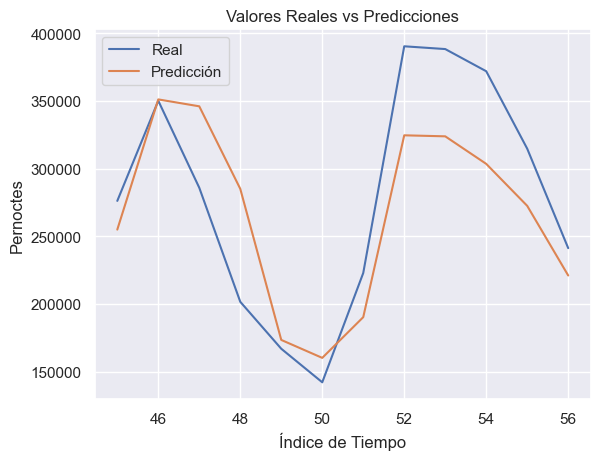

Mean Squared Error: 2317342853.465637
r2: 0.6575336554330303


In [119]:



# Definir las features (X) y la target (y)
features = ['valor_mes_anterior', 'Mes_10', 'Mes_11', 'Mes_12', 'Mes_2', 'Mes_3', 'Mes_4',
       'Mes_5', 'Mes_6', 'Mes_7', 'Mes_8', 'Mes_9', 'Año_2020',
       'Año_2021', 'Año_2022', 'Año_2023']
target = 'pernoctes'

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    return r2

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los resultados de la optimización
print('Mejores hiperparámetros:', study.best_params)
print('Mejor valor de r2:', study.best_value)

# Obtener el modelo con los mejores hiperparámetros
best_params = study.best_params
best_model_cd = xgb.XGBRegressor(**best_params)

# Entrenar el modelo con todos los datos de entrenamiento
best_model_cd.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model_cd.predict(X_test)

# Mostrar los valores reales y las predicciones
results_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(results_df)

# Graficar los resultados
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Pernoctes')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')


#### XGBoostRegressor sin dummies

[I 2024-03-15 15:52:12,226] A new study created in memory with name: no-name-0ec1f220-35e9-4c8d-b664-ca090c948358
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_16992/2270071952.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_16992/2270071952.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
/Users/silvinademicco/anaconda3/envs/silvina2024/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

Mejores hiperparámetros: {'booster': 'dart', 'lambda': 9.436791066453223e-07, 'alpha': 0.00014226953212452916, 'colsample_bytree': 0.9185085217991855, 'subsample': 0.9519831138647674, 'learning_rate': 0.2342288592633937, 'n_estimators': 131, 'max_depth': 3, 'min_child_weight': 3}
Mejor valor de r2: 0.9224225249514759
        Real     Predicción
45  276215.0  196789.687500
46  350187.0  287114.718750
47  285907.0  328377.312500
48  201686.0  205580.484375
49  167006.0  187747.625000
50  142228.0  203854.921875
51  222950.0  237267.265625
52  390398.0  390703.531250
53  388352.0  362671.187500
54  371970.0  382808.781250
55  314773.0  305667.843750
56  241320.0  254718.578125


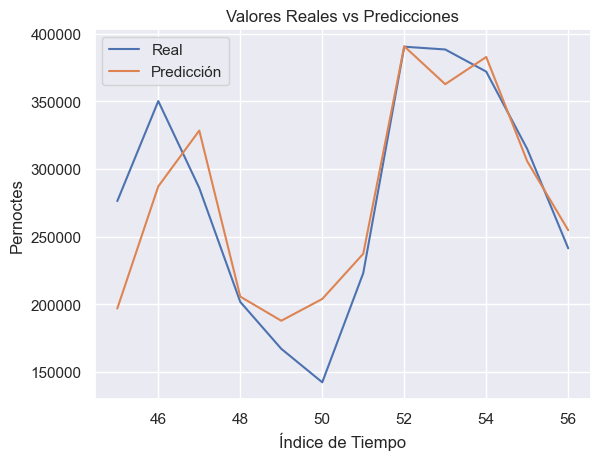

Mean Squared Error: 791328981.957723
Mean Absolute Error: 23723.0703125
r2: 0.8830541870851475


In [138]:

# Ordenar por 'indice_tiempo'
df = df.sort_values(by='indice_tiempo')

# Imputar valores nulos
df = df.dropna()
# Definir las features (X) y la target (y)
features = ['valor_mes_anterior','Mes','Año']
target = 'pernoctes'

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    return r2

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los resultados de la optimización
print('Mejores hiperparámetros:', study.best_params)
print('Mejor valor de r2:', study.best_value)

# Obtener el modelo con los mejores hiperparámetros
best_params = study.best_params
best_model_sd = xgb.XGBRegressor(**best_params)

# Entrenar el modelo con todos los datos de entrenamiento
best_model_sd.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model_sd.predict(X_test)

# Mostrar los valores reales y las predicciones
results_df_sd = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(results_df)

# Graficar los resultados
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Pernoctes')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

# Evaluar el rendimiento del modelo
mse_sd = mean_squared_error(y_test, y_pred)
mae_sd = mean_absolute_error(y_test, y_pred)
r2_sd = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse_sd}')
print(f'Mean Absolute Error: {mae_sd}')
print(f'r2: {r2_sd}')

In [141]:
results_df_sd

,Real,Predicción
45,276215.0,237468.062500
46,350187.0,317776.562500
47,285907.0,330373.250000
48,201686.0,211914.437500
49,167006.0,184572.578125
50,142228.0,190779.078125
51,222950.0,244072.250000
52,390398.0,392745.750000
53,388352.0,378169.125000
54,371970.0,382693.625000


In [145]:
modelo_con_trend = pd.concat([results_df_sd, X_test], axis=1)
modelo_con_trend['Fecha'] = modelo_con_trend['Mes'].astype(str) + '/' + modelo_con_trend['Año'].astype(str)
modelo_con_trend['Fecha'] = pd.to_datetime(modelo_con_trend['Fecha'], format='%m/%Y')

In [151]:
modelo_con_trend
modelo_con_trend['total_plazas_mes']=(modelo_con_trend['Mes'].replace(dic_mes))*24653
modelo_con_trend['ocupacion_real']=(modelo_con_trend['Real'] /modelo_con_trend['total_plazas_mes'])*100
modelo_con_trend['ocupacion_Prediccion']=(modelo_con_trend['Predicción'] /modelo_con_trend['total_plazas_mes'])*100

In [152]:
modelo_con_trend.columns

Index(['Real', 'Predicción', 'Mes', 'Año', 'Fecha', 'total_plazas_mes',
       'ocupacion_real', 'ocupacion_Prediccion'],
      dtype='object')

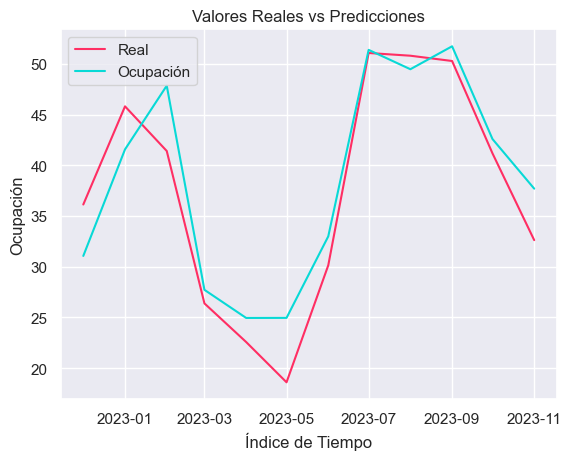

In [161]:
plt.plot(modelo_con_trend['Fecha'], modelo_con_trend['ocupacion_real'], label='Real',color='#FF2E63')
plt.plot(modelo_con_trend['Fecha'], modelo_con_trend['ocupacion_Prediccion'], label='Predicción',color='#08D9D6')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Ocupación')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

[I 2024-03-15 15:54:02,773] A new study created in memory with name: no-name-ea3518a8-29bb-4b57-92bb-a2a7967afbe1
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_16992/362120955.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_16992/362120955.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
[I 2024-03-15 15:54:02,879] Trial 0 finished with value: -0.48638190879958043 and parameters: {'booster': 'gbtree', 'lambda': 0.0032332256439319648, 'alpha': 7.1805352722750275e-06, 'colsample_byt

Mejores hiperparámetros: {'booster': 'gbtree', 'lambda': 0.18148763697835493, 'alpha': 0.6572654186592627, 'colsample_bytree': 0.16819104473183397, 'subsample': 0.21898770207587098, 'learning_rate': 0.14774149702161854, 'n_estimators': 278, 'max_depth': 15, 'min_child_weight': 1}
Mejor valor de r2: 0.7317390659356675
        Real     Predicción
45  276215.0  196789.687500
46  350187.0  287114.718750
47  285907.0  328377.312500
48  201686.0  205580.484375
49  167006.0  187747.625000
50  142228.0  203854.921875
51  222950.0  237267.265625
52  390398.0  390703.531250
53  388352.0  362671.187500
54  371970.0  382808.781250
55  314773.0  305667.843750
56  241320.0  254718.578125


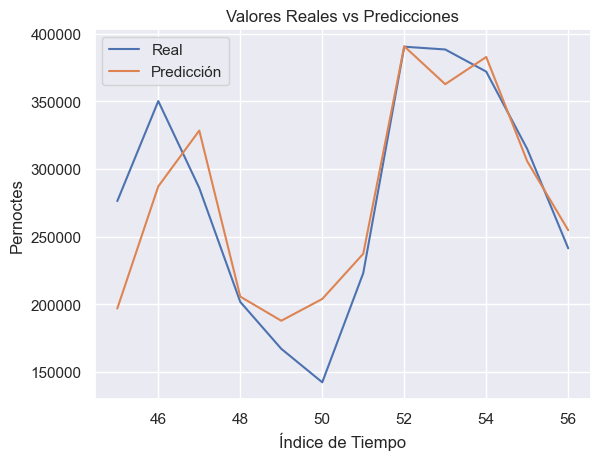

Mean Squared Error: 3942592362.8820395
Mean Absolute Error: 52557.143229166664
r2: 0.41734767791714455


In [140]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import optuna

# Ordenar por 'indice_tiempo'
df = df.sort_values(by='indice_tiempo')

# Imputar valores nulos
df = df.dropna()

# Definir las features (X) y la target (y)
features_1 = ['Mes','Año']
target = 'pernoctes'

X = df[features_1]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    return r2

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los resultados de la optimización
print('Mejores hiperparámetros:', study.best_params)
print('Mejor valor de r2:', study.best_value)

# Obtener el modelo con los mejores hiperparámetros
best_params = study.best_params
best_model_sv = xgb.XGBRegressor(**best_params)

# Entrenar el modelo con todos los datos de entrenamiento
best_model_sv.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model_sv.predict(X_test)

# Mostrar los valores reales y las predicciones
results_df_sv = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(results_df)

# Graficar los resultados
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Pernoctes')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

# Evaluar el rendimiento del modelo
mse_sv = mean_squared_error(y_test, y_pred)
mae_sv=mean_absolute_error(y_test, y_pred)
r2_sv = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse_sv}')
print(f'Mean Absolute Error: {mae_sv}')
print(f'r2: {r2_sv}')

In [159]:
modelo_sin_trend = pd.concat([results_df_sv, X_test], axis=1)
modelo_sin_trend['Fecha'] = modelo_sin_trend['Mes'].astype(str) + '/' + modelo_sin_trend['Año'].astype(str)
modelo_sin_trend['Fecha'] = pd.to_datetime(modelo_sin_trend['Fecha'], format='%m/%Y')

modelo_sin_trend['total_plazas_mes']=(modelo_sin_trend['Mes'].replace(dic_mes))*24653
modelo_sin_trend['ocupacion_real']=(modelo_sin_trend['Real'] /modelo_sin_trend['total_plazas_mes'])*100
modelo_sin_trend['ocupacion_Prediccion']=(modelo_sin_trend['Predicción'] /modelo_sin_trend['total_plazas_mes'])*100

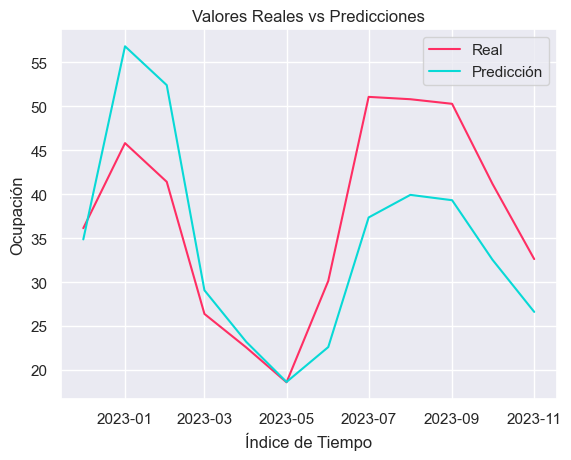

In [160]:
plt.plot(modelo_sin_trend['Fecha'], modelo_sin_trend['ocupacion_real'], label='Real',color='#FF2E63')
plt.plot(modelo_sin_trend['Fecha'], modelo_sin_trend['ocupacion_Prediccion'], label='Predicción',color='#08D9D6')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Ocupación')
plt.title('Valores Reales vs Predicciones')
plt.legend()










plt.show()

### Elijo el ultimo modelos de XGBoost sin dummies (como son pocos datos al aplicar dummies se pierde informacion)
Obtengo los valores de residuos para determinar el intervalo de confianza de la prediccion del modelo con un nivel de significancia de 0.05.

In [1168]:

# Obtener predicciones y residuos en el conjunto de prueba
predicciones = best_model.predict(X_test)
residuos = y_test - predicciones

# Calcular desviación estándar de los residuos en el conjunto de prueba
desviacion_estandar_test = np.std(residuos)

# Construir intervalo de confianza del 95%
intervalo_confianza_test = 1.96 * desviacion_estandar_test
limite_superior_test = predicciones + intervalo_confianza_test
limite_inferior_test = predicciones - intervalo_confianza_test




In [1169]:
print(intervalo_confianza_test)

121692.1635062871


Para estar segura que esta ok aplicar el criterio anterior de intervalo de confianza verifico que los residuos sigan una distribucion normal aplicando la prueba de normalidad de Shapiro-Wilk

Predicción: 324589.5, Intervalo de confianza (Test): (226653.171875, 422525.8125)
Predicción: 258852.15625, Intervalo de confianza (Test): (160915.828125, 356788.5)
Predicción: 402746.625, Intervalo de confianza (Test): (304810.3125, 500682.9375)
Predicción: 327607.25, Intervalo de confianza (Test): (229670.921875, 425543.5625)
Predicción: 246124.09375, Intervalo de confianza (Test): (148187.765625, 344060.4375)
Predicción: 154686.421875, Intervalo de confianza (Test): (56750.09375, 252622.75)
Predicción: 169164.796875, Intervalo de confianza (Test): (71228.46875, 267101.125)
Predicción: 226497.171875, Intervalo de confianza (Test): (128560.84375, 324433.5)
Predicción: 407830.25, Intervalo de confianza (Test): (309893.9375, 505766.5625)
Predicción: 369612.25, Intervalo de confianza (Test): (271675.9375, 467548.5625)
Predicción: 337159.96875, Intervalo de confianza (Test): (239223.640625, 435096.3125)


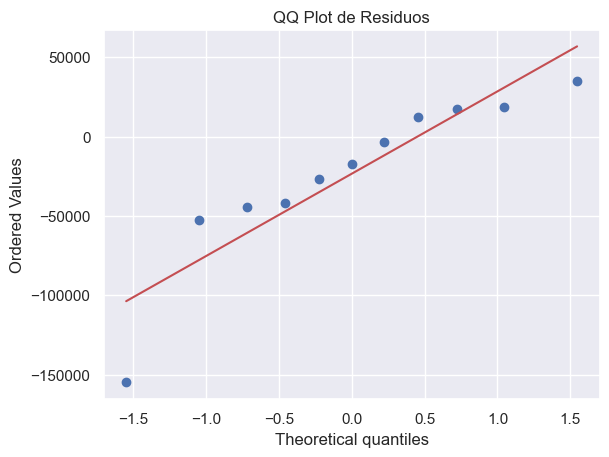

Prueba de Shapiro-Wilk - Estadístico: 0.854784101500729, Valor p: 0.04926476148747413
Los residuos no parecen seguir una distribución normal (p <= 0.05)


In [1157]:
from scipy.stats import shapiro, probplot
for i in range(len(X_test)):
    print(f"Predicción: {predicciones[i]}, Intervalo de confianza (Test): ({limite_inferior_test[i]}, {limite_superior_test[i]})")

# Graficar el QQ plot
probplot(residuos, dist="norm", plot=plt)
plt.title('QQ Plot de Residuos')
plt.show()

# Prueba de normalidad de Shapiro-Wilk
shapiro_test_statistic, shapiro_p_value = shapiro(residuos)
print(f"Prueba de Shapiro-Wilk - Estadístico: {shapiro_test_statistic}, Valor p: {shapiro_p_value}")

# Interpretar los resultados
alpha = 0.05
if shapiro_p_value > alpha:
    print("Los residuos parecen seguir una distribución normal (p > 0.05)")
else:
    print("Los residuos no parecen seguir una distribución normal (p <= 0.05)")

Creo un grafico con los valores reales, las predicciones y los intervalos de confiaza. 

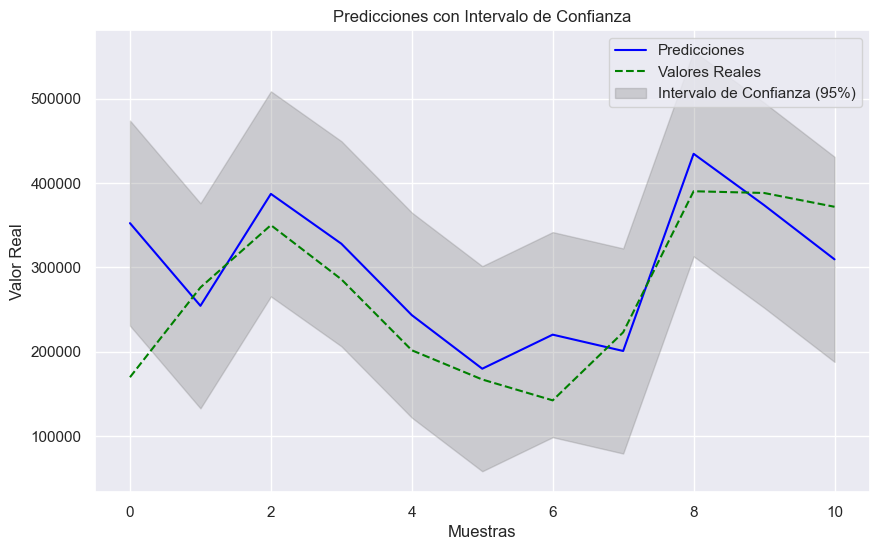

In [1170]:
# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar las predicciones
plt.plot(predicciones, label='Predicciones', color='blue')
# Graficar los valores reales
plt.plot(y_test.values, label='Valores Reales', color='green', linestyle='--')

# Graficar el intervalo de confianza en gris
plt.fill_between(range(len(y_test)), limite_inferior_test, limite_superior_test, color='gray', alpha=0.3, label='Intervalo de Confianza (95%)')

# Añadir etiquetas y leyenda
plt.xlabel('Muestras')
plt.ylabel('Valor Real')
plt.title('Predicciones con Intervalo de Confianza')
plt.legend()

# Mostrar el gráfico
plt.show()


Guardo el modelo para luego tomarlo en la app streamlit

In [1159]:
#best_model.save_model('xgb_model_turismo_6.json')

In [1160]:
X_test_final = pd.concat([X_test, results_df['Predicción']], axis=1)

In [1161]:
X_test_final = pd.concat([X_test_final, results_df['Real']], axis=1)

In [1162]:
X_test_final 

,valor_mes_anterior,Mes,Año,Predicción,Real
44,38.20,11,2022,324589.500000,169688.0
45,29.50,12,2022,258852.156250,276215.0
46,43.50,1,2023,402746.625000,350187.0
47,84.20,2,2023,327607.250000,285907.0
48,56.25,3,2023,246124.093750,201686.0
49,35.75,4,2023,154686.421875,167006.0
50,39.40,5,2023,169164.796875,142228.0
51,35.00,6,2023,226497.171875,222950.0
52,46.00,7,2023,407830.250000,390398.0
53,47.40,8,2023,369612.250000,388352.0


In [1163]:
X_test_final['Fecha'] = X_test_final['Mes'].astype(str) + '/' + X_test_final['Año'].astype(str)
X_test_final['Fecha'] = pd.to_datetime(X_test_final['Fecha'], format='%m/%Y')

In [1164]:
valores_reales=X_test_final[['Fecha','Mes','Año','Real','valor_mes_anterior']]

In [ ]:
dic_mes ={
    1: 31,
    2: 28,
    3: 31,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31
}

In [1101]:
valores_reales['cantidad_dias']=valores_reales['Mes'].replace(dic_mes)

In [1102]:
valores_reales['total_plazas_mes']=valores_reales['cantidad_dias']*24653


In [1103]:
valores_reales['ocupacion_real']=(valores_reales['Real']/valores_reales['total_plazas_mes'])*100


In [1104]:
valores_reales

,Fecha,Mes,Año,Real,valor_mes_anterior,cantidad_dias,total_plazas_mes,ocupacion_real
44,2022-11-01,11,2022,169688.0,38.20,30,739590,22.943523
45,2022-12-01,12,2022,276215.0,29.50,31,764243,36.142300
46,2023-01-01,1,2023,350187.0,43.50,31,764243,45.821421
47,2023-02-01,2,2023,285907.0,84.20,28,690284,41.418749
48,2023-03-01,3,2023,201686.0,56.25,31,764243,26.390297
49,2023-04-01,4,2023,167006.0,35.75,30,739590,22.580889
50,2023-05-01,5,2023,142228.0,39.40,31,764243,18.610311
51,2023-06-01,6,2023,222950.0,35.00,30,739590,30.145080
52,2023-07-01,7,2023,390398.0,46.00,31,764243,51.082967
53,2023-08-01,8,2023,388352.0,47.40,31,764243,50.815251


In [ ]:
#valores_reales.to_csv('valores_reales')

NameError: name 'valores_reales' is not defined

In [ ]:
X_test_final['Fecha'] = X_test_final['Mes'].astype(str) + '/' + X_test_final['Año'].astype(str)


NameError: name 'X_test_final' is not defined

In [ ]:
X_test_final['Fecha'] = pd.to_datetime(X_test_final['Fecha'], format='%m/%Y')

NameError: name 'X_test_final' is not defined

In [ ]:
X_test_final

NameError: name 'X_test_final' is not defined